In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:5000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

5000 2000


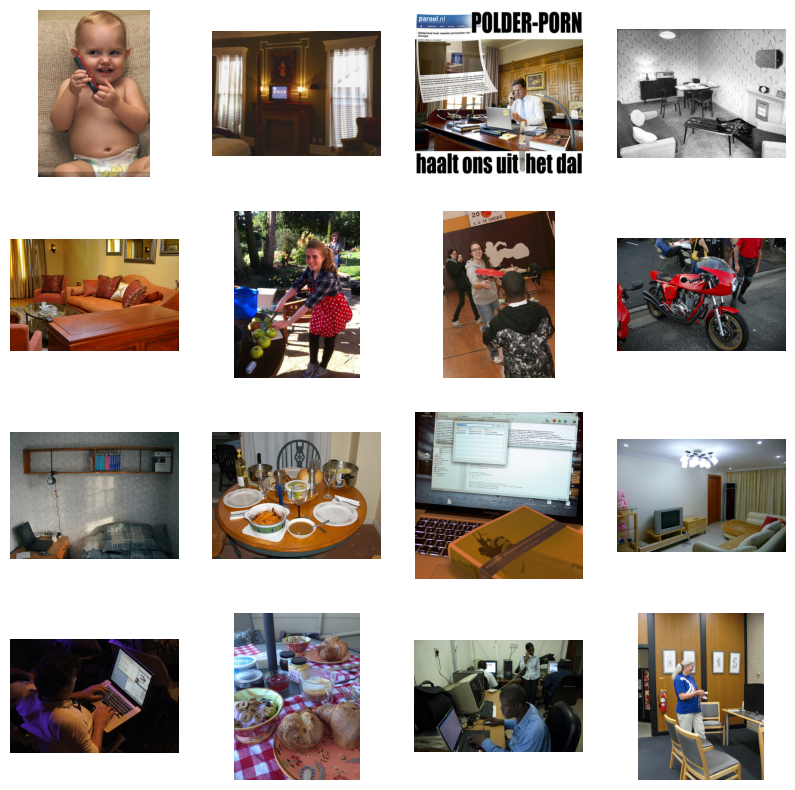

In [5]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [6]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader


In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
313 125


In [8]:
class UnetBlock(nn.Module):
      def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                  innermost=False, outermost=False):
          super().__init__()
          self.outermost = outermost
          if input_c is None: input_c = nf
          downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                              stride=2, padding=1, bias=False)
          downrelu = nn.LeakyReLU(0.2, True)
          downnorm = nn.BatchNorm2d(ni)
          uprelu = nn.ReLU(True)
          upnorm = nn.BatchNorm2d(nf)

          if outermost:
              upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                          stride=2, padding=1)
              down = [downconv]
              up = [uprelu, upconv, nn.Tanh()]
              model = down + [submodule] + up
          elif innermost:
              upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                          stride=2, padding=1, bias=False)
              down = [downrelu, downconv]
              up = [uprelu, upconv, upnorm]
              model = down + up
          else:
              upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                          stride=2, padding=1, bias=False)
              down = [downrelu, downconv, downnorm]
              up = [uprelu, upconv, upnorm]
              if dropout: up += [nn.Dropout(0.5)]
              model = down + [submodule] + up
          self.model = nn.Sequential(*model)

      def forward(self, x):
          if self.outermost:
              return self.model(x)
          else:
              return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)



In [9]:
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                  for i in range(n_down)]  # Adjusting stride for last block
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]  # No normalization or activation for last layer
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm:
            layers += [nn.BatchNorm2d(nf)]
        if act:
            layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [10]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [11]:
# Example usage
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)  # batch_size, channels, size, size
out = discriminator(dummy_input)
print(out.shape)

torch.Size([16, 1, 30, 30])


In [30]:
import torch
import torch.nn as nn

class RobustWGANLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def discriminator_loss(self, real_preds, fake_preds, real_weights):
        # Reshape real_weights to match the shape of real_preds
        real_weights = real_weights.view_as(real_preds)  # This line is added
        # The discriminator loss is the weighted average of the real predictions minus the average of the fake predictions
        weighted_real_loss = torch.mean(real_weights * real_preds)
        return torch.mean(fake_preds) - weighted_real_loss

    def generator_loss(self, fake_preds):
        # The generator loss remains the same as the standard WGAN
        return -torch.mean(fake_preds)

# Example usage
loss = RobustWGANLoss()
real_preds = torch.randn(16, 1)  # Example output of discriminator for real images
fake_preds = torch.randn(16, 1)  # Example output of discriminator for fake images
real_weights = torch.rand(16, 1)  # Example weights for real images, typically calculated during training

# Calculate losses
d_loss = loss.discriminator_loss(real_preds, fake_preds, real_weights)
g_loss = loss.generator_loss(fake_preds)

print("Discriminator Loss:", d_loss.item())
print("Generator Loss:", g_loss.item())


Discriminator Loss: 0.3457854986190796
Generator Loss: -0.5405081510543823


In [13]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [14]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Detach the tensors from their history and set requires_grad to True
    real_samples = real_samples.detach()
    fake_samples = fake_samples.detach()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.shape, requires_grad=False, device=device)
    # Calculate gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [28]:
import torch
from torch import nn, optim
import torch.nn.functional as F

# class WeightNet(nn.Module):
#     def __init__(self, input_channels, ndf=64, output_dim=1):
#         super(WeightNet, self).__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(input_channels, ndf, 3, 1, 1, bias=True),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(ndf, 2 * ndf, 3, 1, 1, bias=True),
#             nn.ReLU(True),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(2 * ndf, output_dim, 4, 1, 0, bias=True)  # Final Conv layer directly outputs the weight
#         )

#     def forward(self, input):
#         weight_logits = self.network(input)
#         weight_logits = torch.sum(weight_logits, (2, 3))
#         return F.relu(weight_logits.view(weight_logits.size(0), -1))
class WeightNet(nn.Module):
    def __init__(self, input_channels=1, ndf=64, output_dim=1):
        super(WeightNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, ndf, 3, 1, 1, bias=True),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(ndf, 2 * ndf, 3, 1, 1, bias=True),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(2 * ndf, output_dim, 4, 1, 0, bias=True)  # Final Conv layer directly outputs the weight
        )

    def forward(self, input):
        weight_logits = self.network(input)
        weight_logits = torch.sum(weight_logits, (2, 3))
        return F.relu(weight_logits.view(weight_logits.size(0), -1))
# class WeightNet(nn.Module):
#     def __init__(self, input_c, num_filters=64, n_down=3):
#         super(WeightNet, self).__init__()
#         model = [self.get_layers(input_c, num_filters, norm=False)]
#         model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
#                   for i in range(n_down)]  # Adjusting stride for last block
#         model += [nn.Conv2d(num_filters * 2 ** n_down, 1, kernel_size=4, stride=1, padding=0, bias=True)]  # Output a single value
#         self.model = nn.Sequential(*model)

#     def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
#         layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
#         if norm:
#             layers += [nn.BatchNorm2d(nf)]
#         if act:
#             layers += [nn.LeakyReLU(0.2, True)]
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         weight = self.model(x)
#         return torch.sigmoid(weight.view(weight.size(0), -1))  # Ensuring the output is between 0 and 1


class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, lr_W=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100., weight_update_iters=1, rho=100):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.weight_update_iters = weight_update_iters
        self.rho = rho

        if net_G is None:
            self.net_G = Unet(input_c=1, output_c=2, n_down=8, num_filters=64).to(self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = PatchDiscriminator(input_c=3, n_down=3, num_filters=64).to(self.device)
        self.net_W = WeightNet(input_channels=3, ndf=64, output_dim=1).to(self.device)

        self.WGANcriterion = RobustWGANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
        self.opt_W = optim.Adam(self.net_W.parameters(), lr=lr_W, betas=(beta1, beta2))

    def set_requires_grad(self, nets, requires_grad=True):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            for p in net.parameters():
                p.requires_grad = requires_grad


    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)


    def backward_D(self, lambda_gp=10):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        real_image = torch.cat([self.L, self.ab], dim=1)

        real_weights = self.net_W(real_image).view(-1)
        fake_preds = self.net_D(fake_image.detach())
        real_preds = self.net_D(real_image)

        self.loss_D = self.WGANcriterion.discriminator_loss(real_preds, fake_preds, real_weights)

        gradient_penalty = compute_gradient_penalty(self.net_D, real_image, fake_image, self.device)
        self.loss_D += lambda_gp * gradient_penalty

        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.WGANcriterion.generator_loss(fake_preds)
        if self.lambda_L1 > 0:  # Optional L1 loss
            self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
            self.loss_G = self.loss_G_GAN + self.loss_G_L1
        else:
            self.loss_G = self.loss_G_GAN
        self.loss_G.backward()


    def optimize(self):
        self.forward()
        self.net_D.train()
        self.net_W.train()

        self.set_requires_grad([self.net_D, self.net_W], True)
        self.opt_D.zero_grad()
        self.opt_W.zero_grad()

        self.backward_D()

        self.opt_D.step()
        self.opt_W.step()

        self.net_G.train()
        self.set_requires_grad([self.net_D, self.net_W], False)
        self.opt_G.zero_grad()

        self.backward_G()

        self.opt_G.step()

    def weight_updates(self, real_data, real_labels, rho):
        # Module for updating weights
        # TODO: define rho??
        # - Excluded vis because just need this to work

        batch_size = 16
        self.opt_W.zero_grad()
        real_weights = self.net_W(real_data, real_labels) # + self.eps # may or may not need this eps. I think its for numerical stability but I didn't verify this.
        real_weights = (real_weights / real_weights.sum()) * batch_size # fix the batch_size variable idk where that is
        real_logits = self.net_D(real_data, real_labels)

        # Chi-squared
        soft_constraint = 100 * torch.nn.functional.relu(torch.mean(0.5 * ((real_weights - 1) ** 2)) - rho)

        loss_weights = self.weight_loss_fn(real_logits, real_weights) + soft_constraint
        loss_weights.backward()
        self.opt_W.step()

In [16]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    loss_W = AverageMeter()  # Adding a meter for weight-related loss

    return {
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G,
        'loss_W': loss_W  # Include this in the returned dictionary
    }

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        if hasattr(model, loss_name):
            loss = getattr(model, loss_name)
            loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


In [ ]:
# def train_model(model, train_dl, epochs, display_every=200):
#     data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
#     for e in range(epochs):
#         loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
#         i = 0                                  # log the losses of the complete network
#         for data in tqdm(train_dl):
#             model.setup_input(data)
#             model.optimize()
#             update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
#             i += 1
#             if i % display_every == 0:
#                 print(f"\nEpoch {e+1}/{epochs}")
#                 print(f"Iteration {i}/{len(train_dl)}")
#                 log_results(loss_meter_dict) # function to print out the losses
#                 visualize(model, data, save=False) # function displaying the model's outputs

# model = MainModel()
# train_model(model, train_dl, 100)

In [17]:
model = MainModel()

In [18]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


In [19]:
from torchvision.models import resnet18

def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate resnet18 as a model
    resnet_model = resnet18(pretrained=True)

    # Create the body of the U-Net using the instantiated resnet18 model
    body = create_body(resnet_model, pretrained=True, n_in=n_input, cut=-2)

    # Create the Dynamic U-Net with the body
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)

    return net_G


In [20]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
#pretrain_generator(net_G, train_dl, opt, criterion, 20)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


# New Section

In [21]:
torch.save(net_G.state_dict(), "res18-unet.pt")

In [31]:
from tqdm import tqdm

def train_model(model, train_dl, epochs, display_every=2000):
    data = next(iter(val_dl))  # for visualizing the model output
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()  # CWGAN-specific loss meters
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)


            # Weight updates (optimize W) (# Line 478 in the train.py file)
            if (i % model.weight_update_iters == 0) and i > 300:
                real_data = data['L'].to(model.device)
                real_labels = data['ab'].to(model.device)
                model.weight_updates(real_data, real_labels, model.rho)


            # optimize D and G
            model.optimize()

            # Update losses
            update_losses(model, loss_meter_dict, count=data['L'].size(0))

            i += 1
            if i % display_every == 0 and e % 10 == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)  # Log CWGAN losses
                visualize(model, data, save=False)

# Load pretrained generator and train the model
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 30)


  0%|          | 0/313 [00:01<?, ?it/s]


OutOfMemoryError: ignored